In [1]:
import torch
import random
import numpy as np

# 设置 Python 内置的随机数生成器的种子
random.seed(42)
# 设置 NumPy 的随机数生成器的种子
np.random.seed(42)
# 设置 PyTorch 随机数生成器的种子
torch.manual_seed(42)
# 如果使用 GPU, 设置 CUDA 随机数生成器的种子
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)  # 如果使用多个 GPU
# 确保所有操作都是确定性的
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [2]:
import numpy as np
import os
from Bio import SeqIO
def load_embeddings(npy_folder_path, max_length, embedding_type='proteinbert'):
    features_dict = {}
    for filename in os.listdir(npy_folder_path):
        if filename.endswith('.npy'):
            protein_id = filename[:-4]
            feature = np.load(os.path.join(npy_folder_path, filename))
            squeezed_feature = np.squeeze(feature)
            if squeezed_feature.shape[0] > max_length:
                padded_feature = squeezed_feature[:max_length, :]
            else:
                padding = np.zeros((max_length - squeezed_feature.shape[0], squeezed_feature.shape[1]))
                padded_feature = np.vstack([squeezed_feature, padding])
            features_dict[protein_id] = padded_feature
    return features_dict

def create_one_hot_features(fasta_file, max_length, amino_acids='ACDEFGHIKLMNPQRSTVWY'):
    aa_to_onehot = {aa: np.eye(len(amino_acids))[i] for i, aa in enumerate(amino_acids)}
    one_hot_features_dict = {}
    for record in SeqIO.parse(fasta_file, "fasta"):
        sequence_id = record.id
        encoded_seq = np.array([aa_to_onehot.get(aa, np.zeros(len(amino_acids))) for aa in str(record.seq)])
        if len(encoded_seq) > max_length:
            encoded_seq = encoded_seq[:max_length]  # 截断超长序列
        padding_length = max_length - len(encoded_seq)
        if padding_length > 0:  # 仅当需要填充时进行填充
            padded_seq = np.pad(encoded_seq, ((0, padding_length), (0, 0)), 'constant')
        else:
            padded_seq = encoded_seq
        one_hot_features_dict[sequence_id] = padded_seq
    return one_hot_features_dict

# 更新最大长度为100
max_length = 160

def combine_features(one_hot_features, proteinbert_features, esm_features):
    combined_features_dict = {}
    for seq_id in one_hot_features:
        if seq_id in proteinbert_features and seq_id in esm_features:
            combined_feature = np.concatenate([
                proteinbert_features[seq_id], 
                esm_features[seq_id], 
                one_hot_features[seq_id]
            ], axis=1)
            combined_features_dict[seq_id] = combined_feature
    return combined_features_dict

#amp_eval_combined_features = combine_features(one_hot_features, proteinbert_features, esm_features)

fasta_file = 'AMP_test.fasta'
proteinbert_path = 'bert_amp_test_embeddings'
esm_path = 'esm_ebd_AMP_test'
one_hot_features = create_one_hot_features(fasta_file, max_length)
proteinbert_features = load_embeddings(proteinbert_path, max_length, 'proteinbert')
esm_features = load_embeddings(esm_path, max_length, 'esm')
amp_test_combined_features = combine_features(one_hot_features, proteinbert_features, esm_features)

fasta_file = 'DECOY_test.fasta'
proteinbert_path = 'bert_DECOY_test_embeddings'
esm_path = 'esm_ebd_DECOY_test'
one_hot_features = create_one_hot_features(fasta_file, max_length)
proteinbert_features = load_embeddings(proteinbert_path, max_length, 'proteinbert')
esm_features = load_embeddings(esm_path, max_length, 'esm')
decoy_amp_test_combined_features = combine_features(one_hot_features, proteinbert_features, esm_features)

In [3]:
from Bio.PDB import PDBParser
import torch
from torch_geometric.data import Data
import numpy as np
import os
import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def get_residue_positions(pdb_file, max_residues=160):
    parser = PDBParser()
    structure = parser.get_structure('PDB', pdb_file)
    model = structure[0]  # Typically, only the first model is used

    residue_positions = []
    for chain in model:
        for residue in chain:
            if residue.id[0] == ' ' and 'CA' in residue:  # Filter out non-standard residues and ensure CA exists
                residue_positions.append(residue['CA'].coord)
                if len(residue_positions) >= max_residues:  # If reached max_residues, stop adding more residues
                    break
        if len(residue_positions) >= max_residues:
            break
    return residue_positions

def build_edges_with_attr(residue_positions, cutoff):
    edges = []
    edge_attrs = []
    num_residues = len(residue_positions)  # Get the number of residues (nodes)
    for i in range(num_residues):
        for j in range(i + 1, num_residues):
            dist = np.linalg.norm(residue_positions[i] - residue_positions[j])
            if dist < cutoff:
                edges.append([i, j])
                edges.append([j, i])
                edge_attrs.append([dist])
                edge_attrs.append([dist])
    # Convert to tensors and add boundary check
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attrs, dtype=torch.float)
    
    # Boundary check
    if edge_index.max().item() >= num_residues:
        raise ValueError(f"Edge index out of bounds! Max index: {edge_index.max().item()}, Num residues: {num_residues}")
    
    return edge_index, edge_attr

def create_graph(feature_array, pdb_file, cutoff=10.0, is_amp=True, max_residues=160):
    residue_positions = get_residue_positions(pdb_file, max_residues)
    edge_index, edge_attr = build_edges_with_attr(residue_positions, cutoff)
    x = torch.tensor(feature_array, dtype=torch.float)
    y = torch.tensor([1 if is_amp else 0], dtype=torch.long)

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)

def create_graphs_for_sequences(features_dict, pdb_folder, is_amp=True, max_residues=160):
    graphs = {}
    for seq_id, features in features_dict.items():
        pdb_file = os.path.join(pdb_folder, f"{seq_id}.pdb")
        if os.path.exists(pdb_file):
            try:
                graph = create_graph(features, pdb_file, is_amp=is_amp, max_residues=max_residues)
                graphs[seq_id] = graph
            except Exception as e:
                logging.error(f"Error processing {seq_id} from {pdb_file}: {e}")
        else:
            logging.warning(f"No PDB file found for {seq_id}")
    return graphs

In [4]:
amp_test_graphs = create_graphs_for_sequences(amp_test_combined_features, 'amp_test_pdb', is_amp=True)
decoy_test_graphs = create_graphs_for_sequences(decoy_amp_test_combined_features, 'DECOY_test_pdb', is_amp=False)

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os

class PeptideDataset(Dataset):
    def __init__(self, root_dir, fasta_file, max_vertices=None):
        self.root_dir = root_dir
        self.peptides = self.parse_fasta(fasta_file)
        self.max_vertices = max_vertices if max_vertices is not None else self.determine_max_vertices()

    def parse_fasta(self, fasta_file):
        peptides = []
        with open(fasta_file, 'r') as file:
            for line in file:
                if line.startswith('>'):
                    peptide_id = line.strip().split()[0][1:]
                    peptides.append(peptide_id)
        return peptides

    def determine_max_vertices(self):
        max_vertices = 0
        for peptide_id in self.peptides:
            path = os.path.join(self.root_dir, peptide_id, 'p1_input_feat.npy')
            if os.path.exists(path):
                current_vertices = np.load(path).shape[0]
                max_vertices = max(max_vertices, current_vertices)
        return max_vertices
    

    def __len__(self):
        return len(self.peptides)

    def __getitem__(self, idx):
        peptide_id = self.peptides[idx]
        try:
            features = {
                'input_feat': np.load(os.path.join(self.root_dir, peptide_id, 'p1_input_feat.npy')),
                'rho_coords': np.load(os.path.join(self.root_dir, peptide_id, 'p1_rho_wrt_center.npy')),
                'theta_coords': np.load(os.path.join(self.root_dir, peptide_id, 'p1_theta_wrt_center.npy')),
                'mask': np.load(os.path.join(self.root_dir, peptide_id, 'p1_mask.npy'))
            }

            max_vertices = 5109  # 设置最大顶点数为5109

            # 调整所有特征到max_vertices
            for key in features:
                current_length = features[key].shape[0]
                if current_length < max_vertices:
                    padding_shape = (max_vertices - current_length,) + features[key].shape[1:]
                    padding = np.zeros(padding_shape, dtype=features[key].dtype)
                    features[key] = np.concatenate((features[key], padding), axis=0)
                elif current_length > max_vertices:
                    features[key] = features[key][:max_vertices]
                
                features[key] = np.nan_to_num(features[key])

            label = 0 # 所有样本的标签都是1
            features_tensor = {key: torch.tensor(val, dtype=torch.float32) for key, val in features.items()}
            return features_tensor, torch.tensor(label, dtype=torch.long)
        except Exception as e:
            print(f"Error loading data for {peptide_id}: {e}")
            return None   # 遇到错误时返回None

In [6]:
root_dir = '/Workspace10/yumengzhang/xingxingpeng/test-data/finger_AMP_test'
fasta_file = '/Workspace10/yumengzhang/xingxingpeng/test-data/AMP_test.fasta'
model2_test_amp_dataset = PeptideDataset(root_dir=root_dir, fasta_file=fasta_file)

In [7]:
root_dir = '/Workspace10/yumengzhang/xingxingpeng/test-data/finger_DECOY_test'
fasta_file = '/Workspace10/yumengzhang/xingxingpeng/test-data/DECOY_test.fasta'
model2_decoy_test_amp_dataset = PeptideDataset(root_dir=root_dir, fasta_file=fasta_file)

In [8]:
GCN_test = list(amp_test_graphs.values())+list(decoy_test_graphs.values())
fingerprint_test = model2_test_amp_dataset + model2_decoy_test_amp_dataset

In [9]:
from torch.utils.data import Dataset
from torch_geometric.data import Batch
class CombinedDataset(Dataset):
    def __init__(self, graph_dataset, feature_dataset):
        assert len(graph_dataset) == len(feature_dataset), "Datasets must be of the same size"
        self.graph_dataset = graph_dataset
        self.feature_dataset = feature_dataset

    def __len__(self):
        return len(self.graph_dataset)

    def __getitem__(self, idx):
        graph_data = self.graph_dataset[idx]
        feature_data, label = self.feature_dataset[idx]
        return graph_data, feature_data, label
    

def custom_collate_fn(batch):
    data_gcn_list = [item[0] for item in batch]  # 提取每个元组的第一部分
    data_masif_list = [item[1] for item in batch]  # 提取每个元组的第二部分

    # 对GCN数据进行批处理
    data_gcn_batch = Batch.from_data_list(data_gcn_list)

    # 对MaSIF数据进行批处理，假设MaSIF数据是一个字典
    masif_keys = data_masif_list[0].keys()
    data_masif_batch = {key: torch.stack([d[key] for d in data_masif_list]) for key in masif_keys}
    
    return data_gcn_batch, data_masif_batch
test_combined_dataset = CombinedDataset(GCN_test, fingerprint_test)
test_combined_loader = DataLoader(test_combined_dataset, batch_size=32, shuffle=True, collate_fn=custom_collate_fn)

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.nn import global_mean_pool

# 定义ImprovedGCN模型
class ImprovedGCN(torch.nn.Module):
    def __init__(self, num_features, num_classes, heads=4, dropout=0.5):
        super(ImprovedGCN, self).__init__()
        # 逐步减少特征维度的层
        self.conv1 = GCNConv(num_features, 1024)
        self.conv2 = GCNConv(1024, 512)
        self.conv3 = GCNConv(512, 256)
        self.conv4 = GCNConv(256, 128)
        self.conv5 = GCNConv(128, 64)
        self.conv6 = GCNConv(64, 32)
        
        self.attn1 = GATConv(32, 16 // heads, heads=heads, concat=True)
        self.fc = nn.Linear(16, num_classes)
        self.dropout = dropout

    def forward(self, data, return_features = False):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
        x = F.relu(self.conv1(x, edge_index, edge_weight=edge_attr))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv2(x, edge_index, edge_weight=edge_attr))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv3(x, edge_index, edge_weight=edge_attr))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv4(x, edge_index, edge_weight=edge_attr))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv5(x, edge_index, edge_weight=edge_attr))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv6(x, edge_index, edge_weight=edge_attr))
        x = F.elu(self.attn1(x, edge_index, edge_attr=edge_attr))
        x = global_mean_pool(x, batch)  
        if return_features:
            return x
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

# 定义MaSIF_site_PyTorch模型
class MaSIF_site_PyTorch(nn.Module):
    def __init__(self, n_thetas, n_rhos, n_feat, n_rotations, dropout_rate=0.5):
        super(MaSIF_site_PyTorch, self).__init__()
        self.n_thetas = n_thetas
        self.n_rhos = n_rhos
        self.n_feat = n_feat
        self.n_rotations = n_rotations

        # Parameters
        self.mu_rho = nn.Parameter(torch.Tensor(self.n_rotations, 1))
        self.sigma_rho = nn.Parameter(torch.Tensor(self.n_rotations, 1))
        self.mu_theta = nn.Parameter(torch.Tensor(self.n_rotations, 1))
        self.sigma_theta = nn.Parameter(torch.Tensor(self.n_rotations, 1))

        # Initialize parameters
        nn.init.uniform_(self.mu_rho, 0, 1)
        nn.init.constant_(self.sigma_rho, 0.5)
        nn.init.uniform_(self.mu_theta, 0, 2 * np.pi)
        nn.init.constant_(self.sigma_theta, 0.5)

        # Layers
        self.avgpool1d = nn.AvgPool1d(kernel_size=6, stride=5)  # Adjust these values based on desired output size
        self.fc1 = nn.Linear(40840, 2)

    def forward(self, input_feat, rho_coords, theta_coords, mask, return_features = False):
        batch_size, n_vertices, num_points, n_feat = input_feat.size()
        input_feat = input_feat.mean(dim=2)

        output_feats = []
        for k in range(self.n_rotations):
            rotated_theta_coords = theta_coords + k * 2 * np.pi / self.n_rotations
            rotated_theta_coords %= 2 * np.pi

            rho_gauss = torch.exp(-torch.square(rho_coords - self.mu_rho[k]) / (2 * torch.square(self.sigma_rho[k]) + 1e-5))
            theta_gauss = torch.exp(-torch.square(rotated_theta_coords - self.mu_theta[k]) / (2 * torch.square(self.sigma_theta[k]) + 1e-5))

            gauss_activations = rho_gauss * theta_gauss * mask
            gauss_activations /= torch.sum(gauss_activations, dim=1, keepdim=True) + 1e-5

            gauss_activations = gauss_activations.unsqueeze(3)
            gauss_activations = gauss_activations.expand(-1, -1, -1, n_feat)

            gauss_desc = torch.sum(gauss_activations * input_feat.unsqueeze(2), dim=2)
            output_feats.append(gauss_desc)
        
        output_feats = torch.cat(output_feats, dim=2)
        #print(output_feats.shape)
        output_feats = output_feats.permute(0, 2, 1)  # [batch_size, 40, 5109]
        #print(output_feats.shape)
        # Apply AvgPool1d to reduce the middle dimension from 5109 to 1000
        output_feats = self.avgpool1d(output_feats)  # [batch_size, 40, 1000]
        #print(output_feats.shape)
        output_feats = output_feats.permute(0, 2, 1)  # [batch_size, 1000, 40]
        #print(output_feats.shape)
        output_feats = output_feats.reshape(batch_size, -1)  # Flatten to feed into the linear layer
        
        if return_features:
            return output_feats

# 设备配置
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# 实例化模型并移至GPU
model_gcn = ImprovedGCN(num_features=3604, num_classes=2).to(device)
model_masif = MaSIF_site_PyTorch(n_thetas=16, n_rhos=5, n_feat=5, n_rotations=8).to(device)

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import global_mean_pool

# 融合模型类
class FusionModel(nn.Module):
    def __init__(self, model_gcn, model_masif, output_features, num_classes):
        super(FusionModel, self).__init__()
        self.model_gcn = model_gcn
        self.model_masif = model_masif
        self.reduce_masif = nn.Linear(40840, 16)
        self.fusion_layer = nn.Linear(output_features, 2)
        

    def forward(self, data_gcn, data_masif):
        # 提取各自模型的特征
        gcn_features = self.model_gcn(data_gcn, return_features=True)
        input_feat = data_masif['input_feat']
        rho_coords = data_masif['rho_coords']
        theta_coords = data_masif['theta_coords']
        mask = data_masif['mask']
        masif_features = self.model_masif(input_feat, rho_coords, theta_coords, mask, return_features=True)
        #print("GCN Features Shape:", gcn_features.shape)
        #print("MaSIF Features Shape:", masif_features.shape)
        masif_features = F.relu(self.reduce_masif(masif_features))
        # 特征融合
        combined_features = torch.cat((gcn_features, masif_features), dim=1)
        combined_features = F.relu(combined_features)
        
        # 分类层
        output = self.fusion_layer(combined_features)
        return F.log_softmax(output, dim=1)

# 设置设备
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# 实例化单独的模型
model_gcn = ImprovedGCN(num_features=3604, num_classes=2).to(device)
model_masif = MaSIF_site_PyTorch(n_thetas=16, n_rhos=5, n_feat=5, n_rotations=8).to(device)

# 假设从GCN和MaSIF模型中提取的特征数量，需要根据具体情况来设置
gcn_output_features = 32  # 假设GCN模型最后一个GAT层输出32维特征
masif_output_features = 5 * 8  # MaSIF模型输出8次旋转的5维特征
total_output_features = 32

# 实例化融合模型
fusion_model = FusionModel(model_gcn, model_masif, 32, num_classes=2).to(device)

Model loaded from 9_12_GCN_finger1.pth


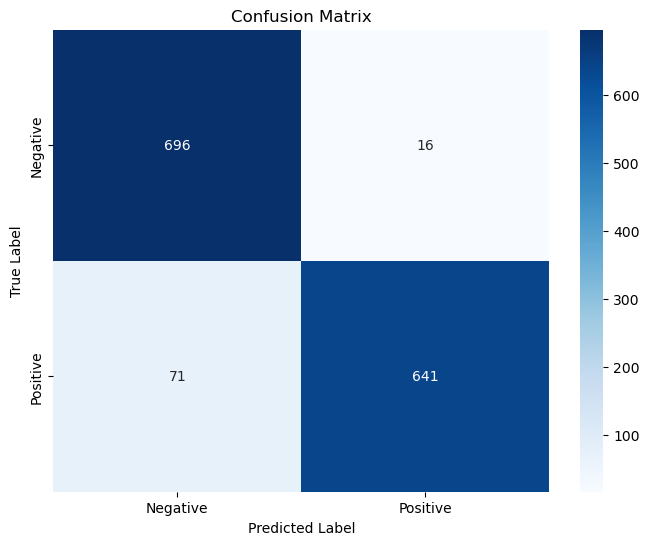

Test Loss: 0.1956, Accuracy: 93.89%, AUC: 0.9732, SENS: 0.9003, SPEC: 0.9775, MCC: 0.8804


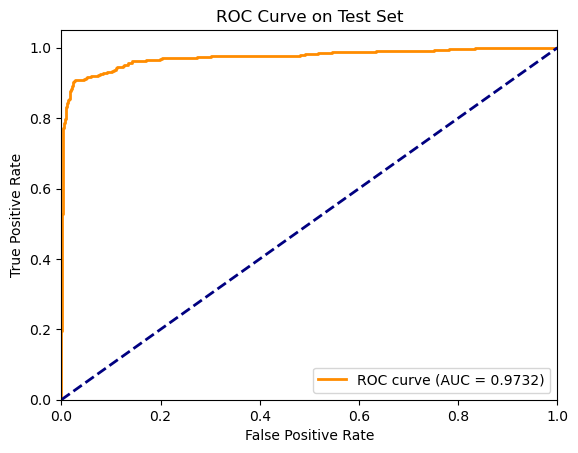

In [12]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, roc_auc_score, matthews_corrcoef, accuracy_score, precision_recall_curve, average_precision_score
import seaborn as sns

# 定义一个加载模型的函数
def load_model(model, path='9_12_GCN_finger1.pth'):
    model.load_state_dict(torch.load(path))
    print(f'Model loaded from {path}')
    return model

# 定义一个绘制 ROC 曲线的函数
def plot_roc_curve(labels, scores, title="ROC Curve"):
    fpr, tpr, _ = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)
    #np.save('ROC_6layerGCN_finger_fpr.npy', fpr)
    #np.save('ROC_6layerGCN_finger_tpr.npy', tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # 绘制对角线
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()
def plot_pr_curve(labels, scores, title="Precision-Recall Curve"):
    precision, recall, _ = precision_recall_curve(labels, scores)
    #np.save('PR_gcn_fingerprint_precision.npy', precision)
    #np.save('PR_gcn_fingerprint_recall.npy', recall)
    ap = average_precision_score(labels, scores)
    plt.figure()
    plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AP = {ap:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

# 使用最佳模型在测试集上进行测试并打印所有指标
def test_model_and_print_metrics(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    total_correct = 0
    total_samples = 0
    all_labels = []
    all_scores = []  # 用于保存正类的概率
    all_preds = []   # 保存预测值

    with torch.no_grad():
        for data_gcn, data_masif in test_loader:
            # 数据处理
            data_gcn.to(device)
            input_feat = data_masif['input_feat'].to(device)
            rho_coords = data_masif['rho_coords'].to(device)
            theta_coords = data_masif['theta_coords'].to(device)
            mask = data_masif['mask'].to(device)
            labels = data_gcn.y.to(device)

            # 正向传播
            outputs = model(data_gcn, {'input_feat': input_feat, 'rho_coords': rho_coords, 'theta_coords': theta_coords, 'mask': mask})
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            # 获取预测概率和预测值
            scores = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()  # 获取正类的预测概率
            preds = torch.argmax(outputs, dim=1).cpu().numpy()  # 获取预测值
            labels = labels.cpu().numpy()

            all_labels.extend(labels)
            all_scores.extend(scores)  # 保存正类的预测概率
            all_preds.extend(preds)    # 保存预测值
            total_correct += (preds == labels).sum()
            total_samples += labels.shape[0]

    # 计算测试集损失
    test_loss /= len(test_loader)

    # 计算 Accuracy
    accuracy = total_correct / total_samples * 100

    # 计算 AUC
    auc_score = roc_auc_score(all_labels, all_scores)

    # 计算混淆矩阵
    cm = confusion_matrix(all_labels, all_preds)
    #np.save('2finger_GCN_all_labels.npy', all_labels)
    #np.save('2finger_GCN_predictions.npy', all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()
    tn, fp, fn, tp = cm.ravel()
    # 计算 Sensitivity 和 Specificity
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    # 计算 MCC
    mcc = matthews_corrcoef(all_labels, all_preds)

    # 获取当前学习率
    #current_lr = optimizer.param_groups[0]['lr']

    # 打印所有指标
    print(f'Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%, AUC: {auc_score:.4f}, '
          f'SENS: {sensitivity:.4f}, SPEC: {specificity:.4f}, MCC: {mcc:.4f}')
    #print(f'Current learning rate: {current_lr:.8f}')
    
    # 绘制 ROC 曲线
    plot_roc_curve(all_labels, all_scores, title="ROC Curve on Test Set")
    #plot_pr_curve(all_labels, all_scores, title="Precision-Recall Curve on Test Set")
best_model2_path = '9_12_GCN_finger1.pth' 
# 加载模型并进行测试
fusion_model = FusionModel(model_gcn, model_masif, 32, num_classes=2).to(device)
fusion_model.to(device)
# 加载之前保存的最佳模型
fusion_model = load_model(fusion_model, best_model2_path)

# 定义损失函数
criterion = torch.nn.CrossEntropyLoss()

# 使用最佳模型在测试集上进行推理并绘制 ROC 曲线
test_model_and_print_metrics(fusion_model, test_combined_loader, criterion)